<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL/blob/master/FinRL_compare_eRL_RLlib_stablebaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FinRL: Compare ElegantRL, RLlib, and Stablebaselines3

## Install DRL libraries: FinRL, ElegantRL, RLlib

In [1]:
## install elegantrl library
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
## install rllib/ray library
!pip install ray[default]
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-qp4489ct
  Running command git clone -q https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-qp4489ct
     |████████████████████████████████| 79.0 MB 31 kB/s 
     |████████████████████████████████| 448 kB 47.2 MB/s 
  Created wheel for elegantrl: filename=elegantrl-0.3.1-py3-none-any.whl size=65731 sha256=5505977ec2091237a59ed98131fd5fcce8152e86cc0a6a35546e30ae2302dc0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0gka30tf/wheels/52/9a/b3/08c8a0b5be22a65da0132538c05e7e961b1253c90d6845e0c6
  Created wheel for pybullet: filename=pybullet-3.1.7-cp37-cp37m-linux_x86_64.whl size=89750490 sha256=e6e37b1c8e3f4137e29d007a34a43f01d67b35d95b78c85ee2ae40ad9b56826c
  Stored in directory: /root/.cache/pip/wheels/70/1c/62/86c8b68885c24123d87c5392d6678aa2b68a1796c8113e1aa6
Successfully built elegantrl pybullet
     |████████████████████████████████| 51.0 MB 39 kB/s 
     |███████████████████████████████

## Install additional packages

In [2]:
!pip install trading_calendars
!pip install alpaca_trade_api
!pip install ccxt
!pip install jqdatasdk
!pip install wrds

!pip install lz4
!pip install ray[tune]
!pip install tensorboardX
!pip install gputil

     |████████████████████████████████| 108 kB 7.0 MB/s 
  Created wheel for trading-calendars: filename=trading_calendars-2.1.1-py3-none-any.whl size=140937 sha256=7bb4035271f5605f17f0f62010229109277c4bd6c9b5ade696cd53b2e44adae4
  Stored in directory: /root/.cache/pip/wheels/62/9c/d1/46a21e1b99e064cba79b85e9f95e6a208ac5ba4c29ae5962ec
Successfully built trading-calendars
     |████████████████████████████████| 40 kB 5.7 MB/s 
     |████████████████████████████████| 52 kB 2.3 MB/s 
     |████████████████████████████████| 103 kB 68.1 MB/s 
     |████████████████████████████████| 2.0 MB 7.0 MB/s 
     |████████████████████████████████| 3.2 MB 47.3 MB/s 
     |████████████████████████████████| 291 kB 64.3 MB/s 
     |████████████████████████████████| 153 kB 6.2 MB/s 
     |████████████████████████████████| 361 kB 10.7 MB/s 
     |████████████████████████████████| 43 kB 2.8 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
  Created wheel for thriftpy2: filename=thriftpy2-0.4.14

## Import packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use('Agg')
import datetime

from elegantrl.agent import *
from elegantrl.run import *
import torch 
import ray
from finrl.neo_finrl.data_processor import DataProcessor
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


## Train

In [5]:
def train(start_date, end_date, ticker_list, data_source, time_interval, 
          technical_indicator_list, drl_lib, env, agent, if_vix = True,
          **kwargs):
    
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)
    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    #read parameters
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':True}
    env_instance = env(config=env_config)
    
    learning_rate = kwargs.get('learning_rate', 0.00025)
    batch_size = kwargs.get('batch_size', 2**7)
    gamma = kwargs.get('gamma', 0.99)
    seed = kwargs.get('seed', 312)
    total_timesteps = kwargs.get('total_timesteps', 1e6)
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(agent))
    
    #train using different libraries
    if drl_lib == 'elegantrl':
        
        if agent == 'ppo':
            args = Arguments(agent=AgentPPO(), env=env_instance, if_on_policy=True)
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        try:
            args.cwd = cwd
            args.learning_rate = learning_rate
            args.batch_size = batch_size
            args.gamma = gamma
            args.seed = seed
            args.break_step = total_timesteps
            args.net_dimension = net_dimension
        except:
            print('Invalid parameters input! Use default value.')
            args.learning_rate = 0.00025
            args.batch_size = 128
            args.gamma = 0.99
            args.seed = 312
            args.break_step = 1e6
            args.net_dimension = 2**7
            
        train_and_evaluate(args)
        
    elif drl_lib == 'rllib':
        ray.init(ignore_reinit_error=True)
        if agent == 'ppo':
            from ray.rllib.agents import ppo
            from ray.rllib.agents.ppo.ppo import PPOTrainer
            try:
                total_episodes = kwargs.get('total_episodes')
            except:
                print('total training episodes is not given! Use default value 1000')
                total_episodes = 1000
            config = ppo.DEFAULT_CONFIG.copy()
            config['env'] = env
            config["log_level"] = "WARN"
            config['env_config'] = {'price_array':price_array,
                                    'tech_array':tech_array,
                                    'turbulence_array':turbulence_array,
                                    'if_train':True}
            trainer = PPOTrainer(env=env, config=config)
            for i in range(total_episodes):
                trainer.train()
            trainer.save(cwd)
        
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                 supported yet.')
            
    elif drl_lib == 'stable_baselines3':
        
        if agent == 'ppo':
            from stable_baselines3 import PPO
            from stable_baselines3.common.vec_env import DummyVecEnv
            
            env_train = DummyVecEnv([lambda : env_instance])
            model = PPO("MlpPolicy", env_train, learning_rate=learning_rate, 
                        n_steps=2048, batch_size=batch_size, ent_coef=0.0, 
                        gamma=gamma, seed=seed)
            model.learn(total_timesteps=total_timesteps, tb_log_name = 'ppo')
            print('Training finished!')
            model.save(cwd)
            print('Trained model saved in ' + str(cwd))
    
    else:
        raise ValueError('DRL library input is NOT supported. Please check.')

## Test

In [6]:
def test(start_date, end_date, ticker_list, data_source, time_interval, 
         technical_indicator_list, drl_lib, env, agent, if_vix = True,
         **kwargs):
    #fetch data
    DP = DataProcessor(data_source, **kwargs)
    data = DP.download_data(ticker_list, start_date, end_date, time_interval)
    data = DP.clean_data(data)
    data = DP.add_technical_indicator(data, technical_indicator_list)

    if if_vix:
        data = DP.add_vix(data)
    price_array, tech_array, turbulence_array = DP.df_to_array(data, if_vix)
    
    env_config = {'price_array':price_array,
            'tech_array':tech_array,
            'turbulence_array':turbulence_array,
            'if_train':False}
    env_instance = env(config=env_config)
    
    net_dimension = kwargs.get('net_dimension', 2**7)
    cwd = kwargs.get('cwd','./'+str(agent))
    print("price_array: ",len(price_array))
    #test on elegantrl
    if drl_lib == 'elegantrl':
        
        #select agent
        if agent == 'ppo':
            args = Arguments(agent=AgentPPO(), env=env_instance, if_on_policy=True)
        else:
            raise ValueError('Invalid agent input or the agent input is not \
                             supported yet.')
        
        #load agent
        try:
            state_dim = env_instance.state_dim
            action_dim = env_instance.action_dim
    
            agent = args.agent
            net_dim = net_dimension
    
            agent.init(net_dim, state_dim, action_dim)
            agent.save_load_model(cwd=cwd, if_save=False)
            act = agent.act
            device = agent.device
    
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        _torch = torch
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        with _torch.no_grad():
            for i in range(env_instance.max_step):
                s_tensor = _torch.as_tensor((state,), device=device)
                a_tensor = act(s_tensor)  # action_tanh = act.forward()
                action = a_tensor.detach().cpu().numpy()[0]  # not need detach(), because with torch.no_grad() outside
                state, reward, done, _ = env_instance.step(action)

                total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
                episode_total_assets.append(total_asset)
                episode_return = total_asset / env_instance.initial_total_asset
                episode_returns.append(episode_return)
                if done:
                    break
                ##print(i)
        print('Test Finished!')
        #return episode returns on testing data
        return episode_total_assets
    
    #test using rllib
    elif drl_lib == 'rllib':
        #load agent
        from ray.rllib.agents import ppo
        from ray.rllib.agents.ppo.ppo import PPOTrainer
        config = ppo.DEFAULT_CONFIG.copy()
        config['env'] = env
        config["log_level"] = "WARN"
        config['env_config'] = {'price_array':price_array,
                                'tech_array':tech_array,
                                'turbulence_array':turbulence_array,
                                'if_train':False}
        
        trainer = PPOTrainer(env=env, config=config)
        try:
            trainer.restore(cwd)
            print("Restoring from checkpoint path", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = trainer.compute_single_action(state)
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        print('episode return: ' + str(episode_return))
        print('Test Finished!')   
        return episode_total_assets

          #test using stable baselines3
    elif drl_lib == 'stable_baselines3':
        from stable_baselines3 import PPO

        try:
            #load agent
            model = PPO.load(cwd)
            print("Successfully load model", cwd)
        except:
            raise ValueError('Fail to load agent!')
        
        #test on the testing env
        state = env_instance.reset()
        episode_returns = list()  # the cumulative_return / initial_account
        episode_total_assets = list()
        episode_total_assets.append(env_instance.initial_total_asset)
        done = False
        while not done:
            action = model.predict(state)[0]
            state, reward, done, _ = env_instance.step(action)
    
            total_asset = env_instance.amount + (env_instance.price_ary[env_instance.day] * env_instance.stocks).sum()
            episode_total_assets.append(total_asset)
            episode_return = total_asset / env_instance.initial_total_asset
            episode_returns.append(episode_return)
        
        print('episode_return', episode_return)
        print('Test Finished!')   
        return episode_total_assets
    
    else:
        raise ValueError('DRL library input is NOT supported yet. Please check.')

## DRL Environment

In [7]:
from finrl.neo_finrl.env_stock_trading.env_stocktrading_np import StockTradingEnv

In [8]:
import numpy as np
import os
import gym
from numpy import random as rd

class StockTradingEnv(gym.Env):

    def __init__(self, config, initial_account=1e6,
                 gamma=0.99, turbulence_thresh=99, min_stock_rate=0.1,
                 max_stock=1e2, initial_capital=1e6, buy_cost_pct=1e-3, 
                 sell_cost_pct=1e-3,reward_scaling=2 ** -11,  initial_stocks=None,
                 ):
        price_ary = config['price_array']
        tech_ary = config['tech_array']
        turbulence_ary = config['turbulence_array']
        if_train = config['if_train']
        n = price_ary.shape[0]
        price_ary = price_ary[int(0.1*n):]
        tech_ary = tech_ary[int(0.1*n):]
        turbulence_ary = turbulence_ary[int(0.1*n):]
        self.price_ary =  price_ary.astype(np.float32)
        self.tech_ary = tech_ary.astype(np.float32)
        self.turbulence_ary = turbulence_ary
        
        self.tech_ary = self.tech_ary * 2 ** -7
        self.turbulence_bool = (turbulence_ary > turbulence_thresh).astype(np.float32)
        self.turbulence_ary = (self.sigmoid_sign(turbulence_ary, turbulence_thresh) * 2 ** -5).astype(np.float32)

        stock_dim = self.price_ary.shape[1]
        self.gamma = gamma
        self.max_stock = max_stock
        self.min_stock_rate = min_stock_rate
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.initial_capital = initial_capital
        self.initial_stocks = np.zeros(stock_dim, dtype=np.float32) if initial_stocks is None else initial_stocks

        # reset()
        self.day = None
        self.amount = None
        self.stocks = None
        self.total_asset = None
        self.gamma_reward = None
        self.initial_total_asset = None

        # environment information
        self.env_name = 'StockEnv'
        # self.state_dim = 1 + 2 + 2 * stock_dim + self.tech_ary.shape[1]
        # # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.state_dim = 1 + 2 + 3 * stock_dim + self.tech_ary.shape[1]
        # amount + (turbulence, turbulence_bool) + (price, stock) * stock_dim + tech_dim
        self.stocks_cd = None
        self.action_dim = stock_dim
        self.max_step = self.price_ary.shape[0] - 1
        self.if_train = if_train
        self.if_discrete = False
        self.target_return = 2.2
        self.episode_return = 0.0
        
        self.observation_space = gym.spaces.Box(low=-3000, high=3000, shape=(self.state_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,), dtype=np.float32)
        
    def reset(self):
        self.day = 0
        price = self.price_ary[self.day]
        
        if self.if_train:
            self.stocks = (self.initial_stocks + rd.randint(0, 64, size=self.initial_stocks.shape)).astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital * rd.uniform(0.95, 1.05) - (self.stocks * price).sum()
        else:
            self.stocks = self.initial_stocks.astype(np.float32)
            self.stocks_cd = np.zeros_like(self.stocks)
            self.amount = self.initial_capital

        self.total_asset = self.amount + (self.stocks * price).sum()
        self.initial_total_asset = self.total_asset
        self.gamma_reward = 0.0
        return self.get_state(price)  # state

    def step(self, actions):
        actions = (actions * self.max_stock).astype(int)

        self.day += 1
        price = self.price_ary[self.day]
        self.stocks_cd += 1

        if self.turbulence_bool[self.day] == 0:
            min_action = int(self.max_stock * self.min_stock_rate)  # stock_cd
            for index in np.where(actions < -min_action)[0]:  # sell_index:
                if price[index] > 0:  # Sell only if current asset is > 0
                    sell_num_shares = min(self.stocks[index], -actions[index])
                    self.stocks[index] -= sell_num_shares
                    self.amount += price[index] * sell_num_shares * (1 - self.sell_cost_pct)
                    self.stocks_cd[index] = 0
            for index in np.where(actions > min_action)[0]:  # buy_index:
                if price[index] > 0:  # Buy only if the price is > 0 (no missing data in this particular date)
                    buy_num_shares = min(self.amount // price[index], actions[index])
                    self.stocks[index] += buy_num_shares
                    self.amount -= price[index] * buy_num_shares * (1 + self.buy_cost_pct)
                    self.stocks_cd[index] = 0

        else:  # sell all when turbulence
            self.amount += (self.stocks * price).sum() * (1 - self.sell_cost_pct)
            self.stocks[:] = 0
            self.stocks_cd[:] = 0

        state = self.get_state(price)
        total_asset = self.amount + (self.stocks * price).sum()
        reward = (total_asset - self.total_asset) * self.reward_scaling
        self.total_asset = total_asset

        self.gamma_reward = self.gamma_reward * self.gamma + reward
        done = self.day == self.max_step
        if done:
            reward = self.gamma_reward
            self.episode_return = total_asset / self.initial_total_asset

        return state, reward, done, dict()

    def get_state(self, price):
        amount = np.array(max(self.amount, 1e4) * (2 ** -12), dtype=np.float32)
        scale = np.array(2 ** -6, dtype=np.float32)
        return np.hstack((amount,
                          self.turbulence_ary[self.day],
                          self.turbulence_bool[self.day],
                          price * scale,
                          self.stocks * scale,
                          self.stocks_cd,
                          self.tech_ary[self.day],
                          ))  # state.astype(np.float32)
    
    @staticmethod
    def sigmoid_sign(ary, thresh):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x * np.e)) - 0.5

        return sigmoid(ary / thresh) * thresh

## Set parameters

In [9]:
env = StockTradingEnv

In [10]:
FAANG_TICKER = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2020-07-31'

TEST_START_DATE = '2020-08-01'
TEST_END_DATE = '2021-07-31'
TECHNICAL_INDICATORS_LIST = ['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

## eRL

### Train

In [11]:
#demo for elegantrl
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = FAANG_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='elegantrl', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo'
      ,total_timesteps=3e5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8280, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AMZN
Data clean for AMZN is finished.
Clean data for FB
Data clean for FB is finished.
Clean data for GOOG
Data clean for GOOG is finished.
Clean data for NFLX
Data clean for NFLX is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1656, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
['AAPL' 'AMZN' 'FB' 'GOOG' 'NFLX']
Successfully transformed into array
| GPU id: 0, cwd: ./test_ppo
| Remove history
ID      Step      MaxR |    avgR      stdR 

### Test

In [19]:
account_value_erl=test(start_date = TEST_START_DATE, 
                        end_date = TEST_END_DATE,
                        ticker_list = FAANG_TICKER, 
                        data_source = 'yahoofinance',
                        time_interval= '1D', 
                        technical_indicator_list= TECHNICAL_INDICATORS_LIST,
                        drl_lib='elegantrl', 
                        env=env, 
                        agent='ppo', 
                        cwd='./test_ppo', 
                        net_dimension = 2 ** 9)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1255, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AMZN
Data clean for AMZN is finished.
Clean data for FB
Data clean for FB is finished.
Clean data for GOOG
Data clean for GOOG is finished.
Clean data for NFLX
Data clean for NFLX is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (250, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
['AAPL' 'AMZN' 'FB' 'GOOG' 'NFLX']
Successfully transformed into array
price_array:  251
Loaded act: ./test_ppo
Test Finished!


### Plot

In [20]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 9)
Annual return          0.311602
Cumulative returns     0.310191
Annual volatility      0.143302
Sharpe ratio           1.972927
Calmar ratio           3.489086
Stability              0.935602
Max drawdown          -0.089308
Omega ratio            1.393095
Sortino ratio          2.920748
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.071375
Daily value at risk   -0.016932
dtype: float64


In [21]:
account_value_erl = pd.DataFrame({'date':baseline_df.date[0:226],'account_value':account_value_erl})

In [22]:
baseline_df.shape

(251, 9)

In [26]:
account_value_erl.shape

(226, 2)

In [25]:
account_value_erl.tail()

,date,account_value
221,2021-06-18,1.191319e+06
222,2021-06-21,1.168154e+06
223,2021-06-22,1.168793e+06
224,2021-06-23,1.159273e+06
225,2021-06-24,1.078330e+06


In [24]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=account_value_erl)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.087726
Cumulative returns     0.078330
Annual volatility      0.211245
Sharpe ratio           0.505429
Calmar ratio           0.695527
Stability              0.515554
Max drawdown          -0.126129
Omega ratio            1.098427
Sortino ratio          0.709966
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.930502
Daily value at risk   -0.026191
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (225, 8)


Start date,2020-08-03
End date,2021-06-23
Total months,10
,Backtest
Annual return,18.002%
Cumulative returns,15.927%
Annual volatility,19.805%
Sharpe ratio,0.94
Calmar ratio,1.43
Stability,0.52
Max drawdown,-12.613%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.61,2020-12-24,2021-01-29,2021-03-08,53
1,9.10,2021-03-24,2021-04-07,2021-05-12,36
2,6.50,2020-11-20,2020-12-09,2020-12-17,20
3,4.58,2021-06-02,2021-06-11,NaT,NaN
4,3.93,2020-12-17,2020-12-22,2020-12-24,6


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


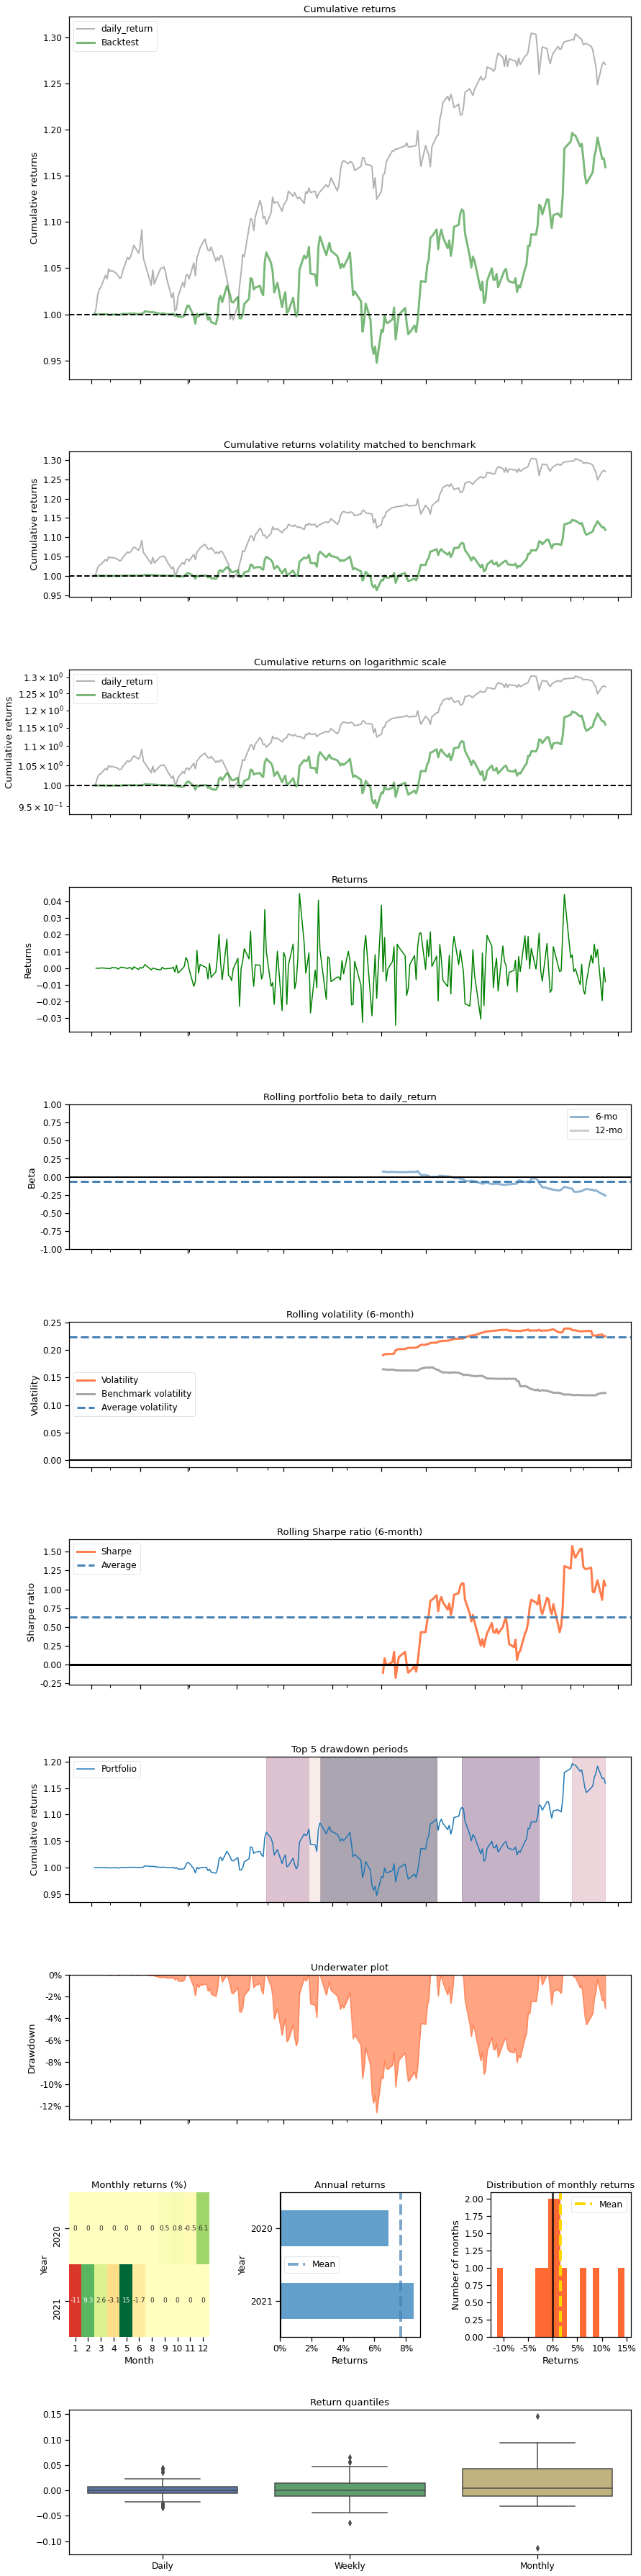

In [18]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_erl, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_erl.loc[0,'date'],
             baseline_end = account_value_erl.loc[len(account_value_erl)-1,'date'])

## RLlib

### Train

In [36]:
#demo for rllib
train(start_date = TEST_START_DATE, 
      end_date = TEST_END_DATE,
      ticker_list = FAANG_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='rllib', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo'
      ,total_episodes=10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1255, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AMZN
Data clean for AMZN is finished.
Clean data for FB
Data clean for FB is finished.
Clean data for GOOG
Data clean for GOOG is finished.
Clean data for NFLX
Data clean for NFLX is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (250, 9)
Clean data for ^VIX


2021-08-16 16:44:53,314	INFO worker.py:811 -- Calling ray.init() again after it has already been called.


Data clean for ^VIX is finished.
Data clean all finished!
['AAPL' 'AMZN' 'FB' 'GOOG' 'NFLX']
Successfully transformed into array


2021-08-16 16:45:12,904	WARNING worker.py:1189 -- The actor or task with ID ffffffffffffffff7629d83d9782e5da030d495e01000000 cannot be scheduled right now. It requires {CPU: 1.000000} for placement, but this node only has remaining {0.000000/2.000000 CPU, 7.328638 GiB/7.328638 GiB memory, 3.664319 GiB/3.664319 GiB object_store_memory, 1.000000/1.000000 node:172.28.0.2}
. In total there are 0 pending tasks and 2 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale or if you specified a runtime_env for this task or actor because it takes time to install.


KeyboardInterrupt: ignored

### Test

In [114]:
test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = FAANG_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST,
     drl_lib='rllib', 
     env=env, 
     agent='ppo', 
     cwd='./test_ppo/checkpoint_000100/checkpoint-100')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1255, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AMZN
Data clean for AMZN is finished.
Clean data for FB
Data clean for FB is finished.
Clean data for GOOG
Data clean for GOOG is finished.
Clean data for NFLX
Data clean for NFLX is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (250, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
['AAPL' 'AMZN' 'FB' 'GOOG' 'NFLX']
Successfully transformed into array
price_array:  251


2021-08-16 16:16:33,828	INFO trainable.py:109 -- Trainable.setup took 16.473 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


ValueError: ignored

## Stable-baselines3

### Train

In [11]:
#demo for stable-baselines3
train(start_date = TRAIN_START_DATE, 
      end_date = TRAIN_END_DATE,
      ticker_list = FAANG_TICKER, 
      data_source = 'yahoofinance',
      time_interval= '1D', 
      technical_indicator_list= TECHNICAL_INDICATORS_LIST,
      drl_lib='stable_baselines3', 
      env=env, 
      agent='ppo', 
      cwd='./test_ppo',
      total_timesteps=100000)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8280, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AMZN
Data clean for AMZN is finished.
Clean data for FB
Data clean for FB is finished.
Clean data for GOOG
Data clean for GOOG is finished.
Clean data for NFLX
Data clean for NFLX is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1656, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
['AAPL' 'AMZN' 'FB' 'GOOG' 'NFLX']
Successfully transformed into array
Training finished!
Trained model saved in ./test_ppo


### Test

In [21]:
account_value_sb3=test(start_date = TEST_START_DATE, 
     end_date = TEST_END_DATE,
     ticker_list = FAANG_TICKER, 
     data_source = 'yahoofinance',
     time_interval= '1D', 
     technical_indicator_list= TECHNICAL_INDICATORS_LIST, 
     drl_lib='stable_baselines3', 
     env=env, 
     agent='ppo', 
     cwd='./test_ppo.zip')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1255, 9)
Clean data for AAPL
Data clean for AAPL is finished.
Clean data for AMZN
Data clean for AMZN is finished.
Clean data for FB
Data clean for FB is finished.
Clean data for GOOG
Data clean for GOOG is finished.
Clean data for NFLX
Data clean for NFLX is finished.
Data clean all finished!
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (250, 9)
Clean data for ^VIX
Data clean for ^VIX is finished.
Data clean all finished!
['AAPL' 'AMZN' 'FB' 'GOOG' 'NFLX']
Successfully transformed into array
price_array:  251
Successfully load model ./test_ppo.zip
episode_return 1.0277450111464879

In [22]:
len(account_value_sb3)

226

### Plot

In [23]:
baseline_df =  DataProcessor('yahoofinance').download_data(ticker_list = ["^DJI"], 
                                                            start_date = TEST_START_DATE, 
                                                            end_date = TEST_END_DATE, 
                                                            time_interval = "1D")
stats = backtest_stats(baseline_df, value_col_name = 'close')


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 9)
Annual return          0.311602
Cumulative returns     0.310191
Annual volatility      0.143302
Sharpe ratio           1.972927
Calmar ratio           3.489086
Stability              0.935602
Max drawdown          -0.089308
Omega ratio            1.393095
Sortino ratio          2.920748
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.071375
Daily value at risk   -0.016932
dtype: float64


In [24]:
account_value_sb3 = pd.DataFrame({'date':baseline_df.date[0:226],'account_value':account_value_sb3})

In [25]:
len(baseline_df.date[0:227])

227

In [26]:
account_value_sb3.tail()

,date,account_value
221,2021-06-18,1.060136e+06
222,2021-06-21,1.045545e+06
223,2021-06-22,1.041145e+06
224,2021-06-23,1.040261e+06
225,2021-06-24,1.027745e+06


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (225, 8)


Start date,2020-08-03
End date,2021-06-23
Total months,10
,Backtest
Annual return,4.52%
Cumulative returns,4.026%
Annual volatility,20.051%
Sharpe ratio,0.32
Calmar ratio,0.35
Stability,0.04
Max drawdown,-12.917%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.92,2020-09-08,2021-01-29,2021-05-28,189
1,4.75,2020-08-03,2020-08-13,2020-08-26,18
2,3.57,2021-06-08,2021-06-11,NaT,NaN
3,2.72,2020-08-28,2020-08-31,2020-09-03,5
4,1.30,2020-08-26,2020-08-27,2020-08-28,3


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


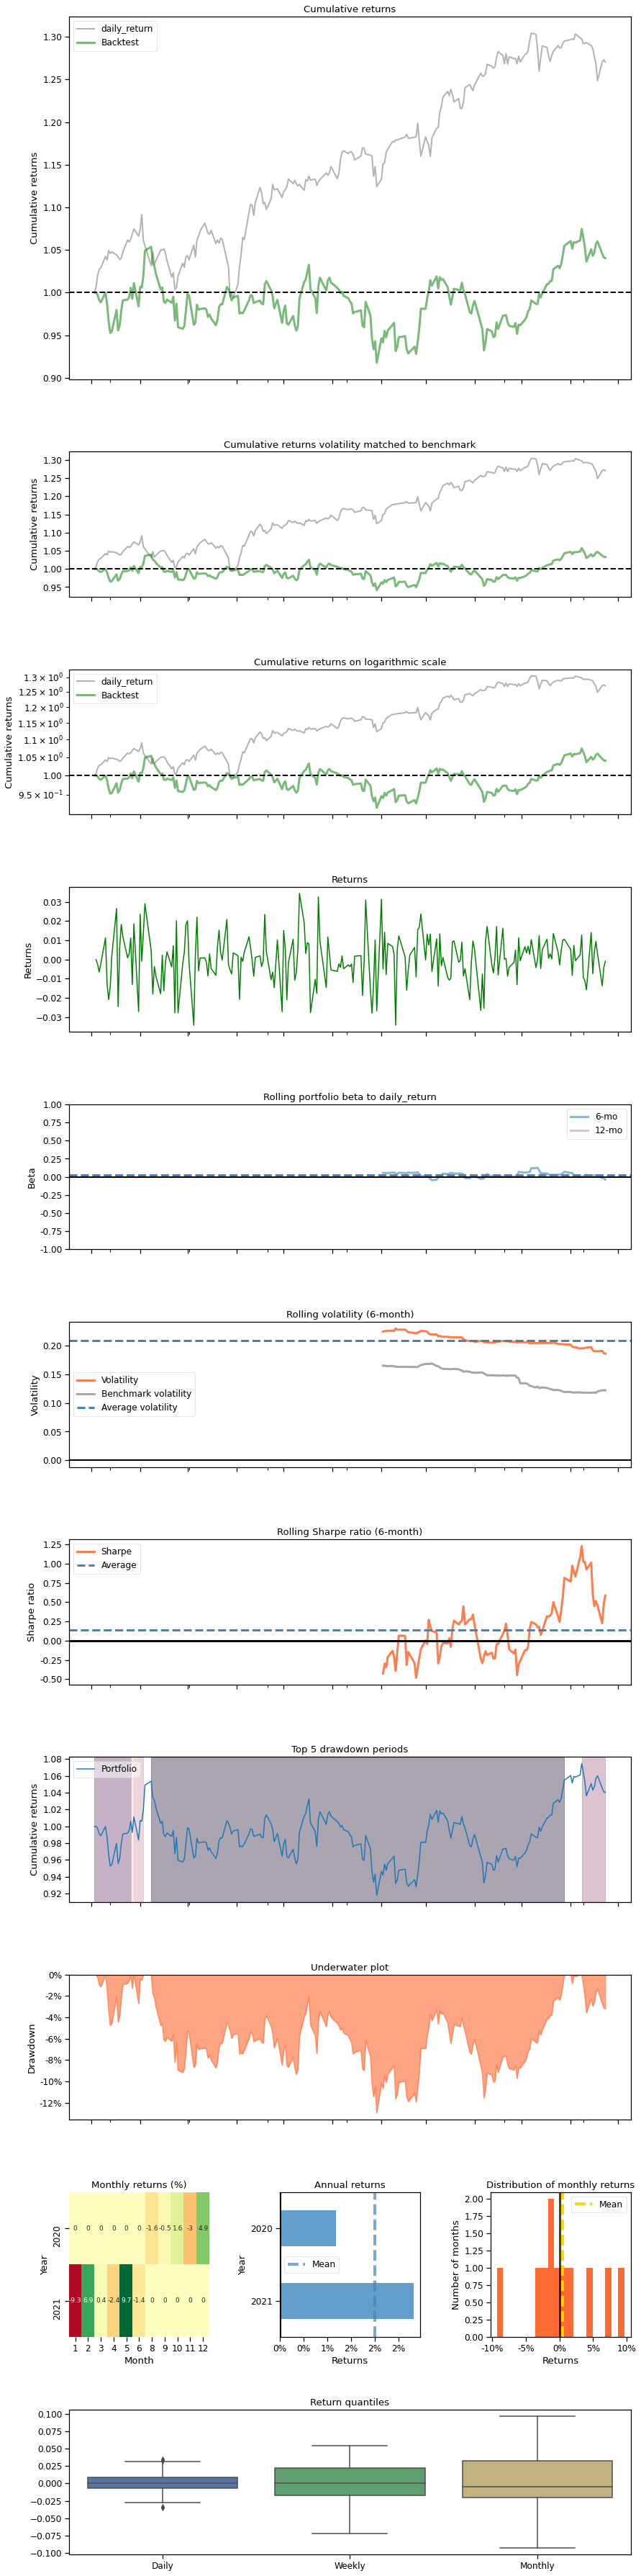

In [19]:
print("==============Compare to DJIA===========")
#%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(account_value_sb3, 
             baseline_ticker = '^DJI', 
             baseline_start = account_value_sb3.loc[0,'date'],
             baseline_end = account_value_sb3.loc[len(account_value_sb3)-1,'date'])